# Projet Analyse de Données : Stratège virtuel de Formule 1

<b>Ce projet porte sur l'étude et l'analyse des résultats et de données de toutes les courses de Formule 1 qui se sont déroulées de 1950 à 2018.</b><br><br>
En Formule 1, de nombreux facteurs sont clés dans la route vers la victoire d'un Grand Prix. On retrouve entre autres : 
<ul>
    <li>La performance de la voiture</li>
    <li>Le talent du pilote</li>
    <li>La position sur la grille (déterminée par une séance de qualification)</li>
    <li>La gestion de l'essence</li>
    <li>La gestion de l'usure des pneus et l'utilisation astucieuse d'arrêts au stand</li>
    <li>La réactivité aux évènements de course comme la tombée de pluie, les accidents sur piste...</li>
</ul>

Dans ce projet, nous allons, entre autres, tenter de prédire la position à l'arrivée d'un pilote, ou bien essayer de déterminer à quel moment de la course un pilote a réalisé un arrêt au stand.<br><br>


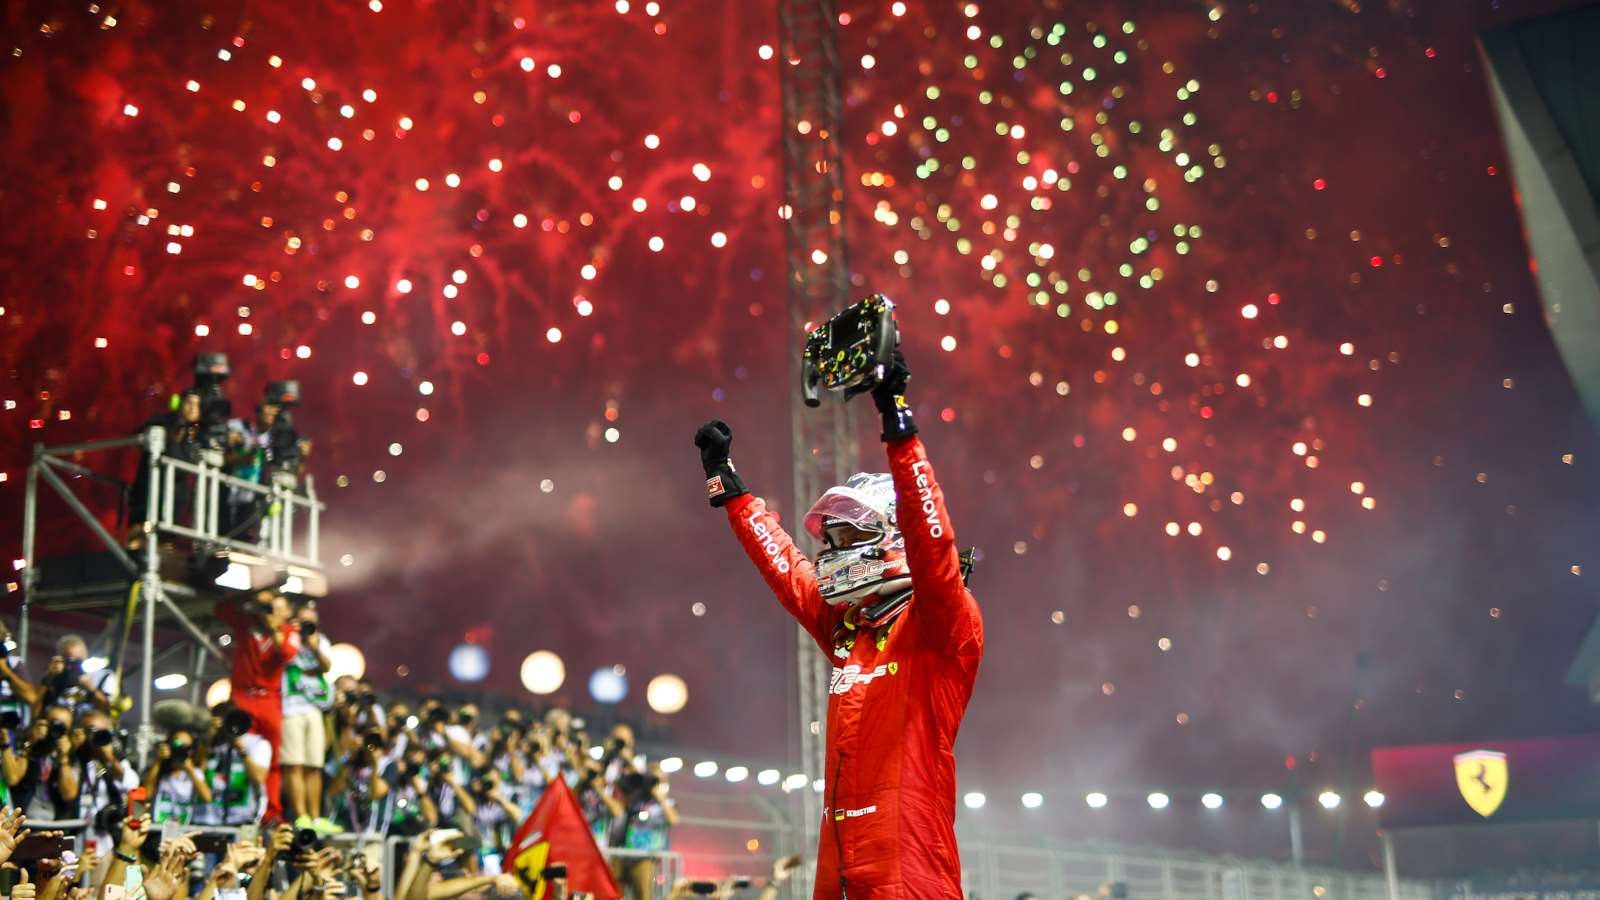


On importe les librairies utiles pour ce projet.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scikitplot as skplt
import warnings
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from collections import Counter
from collections import defaultdict

warnings.filterwarnings("ignore")

sns.set()
mpl.rcParams['figure.figsize'] = (8,6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

On importe le dataset

In [ ]:
circuits = pd.read_csv("datasets/circuits.csv", index_col=0)
constructorResults = pd.read_csv("datasets/constructor_results.csv", index_col=0)
constructors = pd.read_csv("datasets/constructors.csv", index_col=0)
constructorStandings = pd.read_csv("datasets/constructor_standings.csv", index_col=0)
drivers = pd.read_csv("datasets/drivers.csv", index_col=0)
lapTimes = pd.read_csv("datasets/lap_times.csv")
pitStops = pd.read_csv("datasets/pit_stops.csv")
qualifying = pd.read_csv("datasets/qualifying.csv", index_col=0)
races = pd.read_csv("datasets/races.csv",index_col=0)
results = pd.read_csv("datasets/results.csv", index_col=0)
status = pd.read_csv("datasets/status.csv", index_col=0)
tyres = pd.read_csv("datasets/tyres.csv")
races = races.reindex(np.random.permutation(races.index))

## Nettoyage des datasets
Ici, nous allons supprimer les colonnes qui ne nous intéressent pas et qui prennent une place inutile à l'affichage.<br>

In [ ]:
drivers = drivers.drop(columns='url')
circuits = circuits.drop(columns=['alt','url','lat','lng','location'])
constructorResults = constructorResults.drop(columns='status')
constructors = constructors.drop(columns=['url'])
races = races.drop(columns=['url','time'])
# races.index.name = 'raceId'

## Création de quelques fonctions utiles

In [ ]:
def getDriverName(driverId):
    '''
    In : driverId (int) : numéro d'identification du pilote
    Out : nom et prénom du pilote (string)
    '''
    try:
        name = str(drivers['forename'].loc[driverId])+' '+str(drivers['surname'].loc[driverId])
        return name
    except UnicodeDecodeError:
        return driverRef

def getDriverId(forename, surname):
    '''
    In : prénom (string) et nom (string)
    Out : driverId (int)
    '''
    return drivers.index[(drivers['forename'] == forename) & (drivers['surname'] == surname)].tolist()[0]

def getConstructorId(constructor):
    '''
    In : constructor (string) : exemple, "McLaren" ou "Ferrari"
    Out : constructorId (int)
    '''
    return constructors.index[constructors['name'] == constructor].tolist()[0]

def getConstructorName(id):
    '''
    In : constructorId (int)
    Out : nom du constructeur (string)
    '''
    return str(constructors['name'].loc[id])

def getDriversInRace(raceId):
    '''
    In : raceId (int)
    Out : les id des pilotes ayant participé à la course (list(int))
    '''
    drivers = results[results['raceId'] == raceId]
    drivers = drivers['driverId']
    return drivers.tolist()

def getTeammate(raceId,driverId):
    result = results[results['raceId'] == raceId]
    constructor = result[result['driverId'] == driverId]['constructorId'].iloc[0]
    current_round = races['round'].loc[raceId]
    try:
        teammate = result[(results['constructorId'] == constructor) & (results['driverId'] != driverId)]['driverId'].iloc[0]
    except Exception:
        if current_round > 1: #Si ce n'est pas la première course de la saison, on retourne l'équipier de la course précédente
            return getTeammate(raceId-1, driverId)
        else:
            return getTeammate(raceId+1, driverId)
    return teammate

print('Le constructorId de Red Bull Racing est {}'.format(getConstructorId('Red Bull')))
print('Le driverId de Max Verstappen est {}'.format(getDriverId('Max','Verstappen')))
print("L'équipe ayant le constructorId 21 est {}".format(getConstructorName(21)))
print("L'équipier de Lewis Hamilton pendant la course 1010 est {}".format(getDriverName(getTeammate(133,17))))

In [ ]:
def getWCCPoints(year,constructorId):
    '''
    In : year (int)
         constructorId (int)
    Out : le nombre de points au championnat constructeurs en fin de saison (int)
    '''
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings[constructorStandings['constructorId'] == constructorId]
        standings = standings.merge(myRaces,right_index=True,left_on='raceId')
        return standings['points'].iloc[standings.shape[0]-1]
    except Exception:
        print('Impossible de retrouver les points')

def getWCCResult(year, constructorId):
    '''
    In : year (int)
         constructorId (int)
    Out : le classement au championnat constructeur en fin de saison (int)
    '''
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
        standings = standings[standings['round'] == standings['round'].max()]
        standings = standings[standings['constructorId'] == constructorId]
    #     print("L'équipe "+getConstructorName(constructorId)+'('+str(constructorId)+')'+" a terminé "+str(standings['position'].tolist()[0])+"e")
        return standings['position'].tolist()[0]
    except Exception:
        return 5
    
def getWCCPosition(year, myround, constructorId):
    '''
    In : year (int)
         myround (int) : numéro de la course dans la saison
         constructorId (int)
    Out : la position au championnat constructeurs à un moment donné de la saison (int)
    '''
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
        standings = standings[standings['round'] == myround]
        standings = standings[standings['constructorId'] == constructorId]
        return standings['position'].tolist()[0]
    except Exception:
        return 5 #Si c'est la première course de la saison, on simule toutes les écuries comme égales.
    
    
def getWCCStandings(year):
    '''
    In : year (int)
    Out : le classement constructeurs de cette année (DataFrame)
    '''
    myRaces = races[races['year'] == year].sort_values('round')
    standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
    standings = standings[standings['round'] == standings['round'].max()]
    return standings[['constructorId','position']].sort_values('position',ascending=True)

def printQualifying(race):
    '''
    In : race (DataFrame)
    Out : rien :)
    '''
    i=1
    while i < race['grid'].max():
        try:
            print("=========={}==========\n {}           =========={}==========\n                          {}\n".format(i, getDriverName(race['driverId'].iloc[i]),i+1,getDriverName(race['driverId'].iloc[i+1])))
            i+=2
        except Exception:
            i+=1
    

In [ ]:
def getAverageQualifyingPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le résultat moyen en qualifications pour cette saison (float)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    quali = 0
    nbMissing = 0
    for i in range(1,current_round+1):
        myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
        try:
            quali += qualifying[(qualifying['raceId'] == myrace) & (qualifying['driverId'] == driverId)]['position'].iloc[0]
        except Exception: #Si un pilote n'a pas participé à une séance de qualifications
            nbMissing +=1
    quali /= 1.0*(current_round-nbMissing)
    return quali

def getAverageFinalPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le résultat moyen en course pour cette saison (float)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    pos = 0
    nbMissing = 0
    for i in range(1,current_round+1):
        try:
            myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
#             print("{}, {}\r".format(myrace, driverId)),
            pos += results[(results['raceId'] == myrace) & (results['driverId'] == driverId)]['positionOrder'].iloc[0]
        except Exception:
            nbMissing +=1
    pos /= 1.0*(current_round-nbMissing)
    return pos

def getQualiHeadToHead(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : la comparaison directe en qualifications du pilote avec son coéquipier (int)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    res = 0
    for i in range(1,current_round+1):
        myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
        try:
            mypos = qualifying[(qualifying['raceId'] == myrace) & (qualifying['driverId'] == driverId)]['position'].iloc[0]
            teammatepos = qualifying[(qualifying['raceId'] == myrace) & (qualifying['driverId'] == getTeammate(myrace,driverId))]['position'].iloc[0]
            if mypos > teammatepos:
                res -= 1
            else:
                res += 1
        except Exception: #Si un des deux pilotes n'a pas participé à une séance de qualifications
            pass
    return res

def getRaceHeadToHead(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : la comparaison directe en course du pilote avec son coéquipier (int)
    '''
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    res = 0
    for i in range(1,current_round+1):
        try:
            myrace = races[(races['year'] == year) & (races['round'] == i)].index[0]
            mypos = results[(results['raceId'] == myrace) & (results['driverId'] == driverId)]['positionOrder'].iloc[0]
            teammatepos = results[(results['raceId'] == myrace) & (results['driverId'] == getTeammate(raceId,driverId))]['positionOrder'].iloc[0]
            if mypos > teammatepos:
                res -= 1
            else:
                res += 1
        except Exception:
            pass
    return res

Pour un pilote $i$, on crée le coefficient de performance $\mu_i$ de la manière suivante : $\mu_i = 1,1^{((x_j - x_i) + (r_j - r_i))}$ avec
- $x_i$ la position moyenne de qualifications du pilote
- $x_j$ la position moyenne de qualifications de son équipier
- $r_i$ le résultat de course moyen du pilote
- $r_j$ le résultat de course moyen de son équipier

In [ ]:
def computeDriverPerformance(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : Le coefficient de performance du pilote pour la saison en cours (float)
    '''
    teammate = getTeammate(raceId, driverId)
    avg_quali_pos = getAverageQualifyingPosition(raceId, driverId)
    teammate_quali_pos = getAverageQualifyingPosition(raceId, teammate)
    avg_final_pos = getAverageFinalPosition(raceId, driverId)
    teammate_final_pos = getAverageFinalPosition(raceId, teammate)
    quali_h2h = getQualiHeadToHead(raceId,driverId)
    race_h2h = getRaceHeadToHead(raceId,driverId)
    coefficient = (teammate_quali_pos-avg_quali_pos) + (teammate_final_pos-avg_final_pos)
    coefficient = np.power(1.1,coefficient)
    return coefficient

In [ ]:
mydriver = 9
mypower = computeDriverPerformance(1030,mydriver)
print("Le coefficient de performance de {} est {:.2f}".format(getDriverName(mydriver), mypower))
mydriver2 = 20
mypower = computeDriverPerformance(42,mydriver2)
print("Le coefficient de performance de {} est {:.2f}".format(getDriverName(mydriver2), mypower))

In [ ]:
def getInformation(raceId, driverId):
    '''
    Cette fonction permet d'exécuter quelques lignes de code fastidieuses.
    In : raceId (int)
         driverId (int)
    Out : 6 DataFrames correspondant à l'union de chaque DataFrame importé avec le numéro de course et le numéro de pilote.
    '''
    try:
        race = races.loc[raceId] #Find the race
        driver = drivers.loc[driverId] #Find the driver
        result = results[(results['raceId'] == raceId) & (results['driverId'] == driverId)].iloc[0]
        pits = pitStops[(pitStops['raceId'] == raceId) & (pitStops['driverId'] == driverId)]
        quali = qualifying[(qualifying['raceId'] == raceId) & (qualifying['driverId'] == driverId)]
        laps = lapTimes[(lapTimes['raceId'] == raceId) & (lapTimes['driverId'] == driverId)]
        return(race,driver,result,pits,quali,laps)
    except Exception: #Si on a entré un mauvais couple (raceId, driverId)
        print('Impossible de trouver la course n°{}'.format(raceId))
        return getInformation(raceId-1,driverId)

def getRaceInformation(raceId):
    '''
    Cette fonction d'affichage imprime un résumé de la course, avec l'identifiant, le vanqueur et le podium.
    In : raceId (int)
    Out : rien 
    '''
    try:
        race = races.loc[raceId]
        result = results[results['raceId'] == raceId]
        print(result)
        winner = result[result['positionOrder'] == 1]['driverId'].iloc[0]
        print(str(race['year'])+ ' '+str(race['name'])+'\n')
        print('Le vainqueur de la course est : '+getDriverName(winner))
        print('Le podium est composé de :')
        for i in range(0,3):
            print(str(getDriverName(result['driverId'].iloc[i]))+' ('+str(result['driverId'].iloc[i])+') ')
        print('')
    except Exception:
        print('Impossible de trouver la course n°{}'.format(raceId))
        return getRaceInformation(raceId-1)

def getQualifyingPosition(raceId, driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : le résultat de qualifications du pilote (pas forcément égal à la position sur la grille, il peut 
          y avoir des pénalités) (int)    
    '''
    quali = getInformation(raceId,driverId)[4]
    if not quali.empty:
        return quali['position'].iloc[0]
    else :
        return 'Inconnu'
    
def getFastestLapTime(raceId):
    '''
    In : raceId (int)
    Out : le temps en millisecondes du tour de course le plus rapide (int)
    '''
    result = results[results['raceId'] == raceId]
    mylap = result['fastestLapTime'].min()
    minutes = int(mylap.split(":")[0])
    seconds = int(mylap.split(":")[1].split(".")[0])
    milliseconds = int(mylap.split(":")[1].split(".")[1])
    return (60000*minutes+1000*seconds+milliseconds)

def getQualifyingTime(raceId,driverId):
    '''
    In : raceId (int)
         driverId (int)
    Out : le temps en millisecondes du tour de qualifications le plus rapide (int)
    '''
    try:
        quali = qualifying[(qualifying['raceId'] == raceId) & (qualifying['driverId'] == driverId)]
        quali = quali.fillna(value='9:99.999')
        quali = quali.iloc[0]
        mylap = quali[['q1','q2','q3']]
        mylap = mylap.min()
        minutes = int(mylap.split(":")[0])
        seconds = int(mylap.split(":")[1].split(".")[0])
        milliseconds = int(mylap.split(":")[1].split(".")[1])
        return (60000*minutes+1000*seconds+milliseconds)
    except Exception: #Le pilote n'a pas participé aux qualifications (exemple Albon à Shanghai 2019)
        return getQualifyingTime(raceId, getTeammate(raceId,driverId)) #On retourne le temps de qualifications de son coéquipier.

def getRaceReport(raceId, driverId):
    '''
    Cette fonction d'affichage imprime un résumé de course pour un pilote passé en paramètre.
    On imprime le résultat de qualifications, la position sur la grille, la position finale,
    les pit-stops effectués par le pilote si l'information est disponible, on trace un graphique
    de la position tour par tour et du temps au tour.
    In : raceId (int)
         driverId (int)
    '''
    (race,driver,result,pits,quali,laps) = getInformation(raceId,driverId)
    print('{} {} (raceId : {})\n'.format(race['year'],race['name'],race.index.name))
    print('Résumé de course de '+str(driver['forename'])+' '+str(driver['surname'])+'\n')
    print('Résultat de qualification : '+str(getQualifyingPosition(raceId,driverId)))
    print('Position sur la grille de départ : '+str(result['grid'])+'\n')
    print('Position finale : '+str(result['positionText']))
    print('Pit-stops effectués par le pilote : '+str(pits.shape[0]))
    if not pits.empty:   
        display(pits[['lap','duration']])
    if not laps.empty:
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(111)
        plt.fill_between(laps['lap'], laps['position'],color="gold", alpha=0.5)
        ax1.plot(laps['lap'].tolist(), laps['position'].tolist(),color='yellow')
        ax1.set_ylabel('position')
        ax1.set_facecolor('xkcd:white')
        ax2 = ax1.twinx()
        ax2.plot(laps['lap'].tolist(), laps['milliseconds'].tolist(), 'blue')
        ax2.set_ylabel('milliseconds',color='blue')
        ax1.grid(False)
        ax2.grid(False)

def getComparison(raceId,driver1,driver2):
    '''
    Cette fonction d'affichage imprime un head-to-head entre deux pilotes passés en paramètres.
    On trace la comparaison de la position ainsi que la comparaison des temps au tour.
    In : raceId (int)
         driver1 (int)
         driver2 (int)
    '''
    (race,driver,result,pits,quali,laps) =getInformation(raceId,driver1)
    (race2,driver2,result2,pits2,quali2,laps2) =getInformation(raceId,driver2)
    if not laps.empty and not laps2.empty:
        fig = plt.figure(figsize=(14,5),dpi=300)
        ax2 = fig.add_subplot(121)
        l1, = ax2.plot(laps['lap'].tolist(), laps['milliseconds'].tolist(), 'blue')
        l2, = ax2.plot(laps2['lap'].tolist(), laps2['milliseconds'].tolist(), 'red')
        ax2.set_ylabel('milliseconds')
        l1.set_label(getDriverName(driver1))
        l2.set_label(getDriverName(driver2.name))
        ax2.legend()
        ax2.title.set_text('Comparaison des temps au tour')
        
        ax1 = fig.add_subplot(122)
        ax1.set_ylabel('position')
        plt.gca().invert_yaxis()
#         plt.fill_between(laps['lap'], laps['position'],color="blue", alpha=0.1)
#         plt.fill_between(laps2['lap'], laps2['position'],color="red", alpha=0.1)
        l3, = ax1.plot(laps['lap'].tolist(), laps['position'].tolist(),color='blue')
        l3.set_label(getDriverName(driver1))
        l4, = ax1.plot(laps2['lap'].tolist(), laps2['position'].tolist(),color='red')
        l4.set_label(getDriverName(driver2.name))
        ax1.legend()
        ax1.title.set_text('Comparaison de la position')
        plt.tight_layout()
    else:
        print('Comparaison non disponible')


In [ ]:
# # getRaceInformation(840)
# getRaceReport(988,830)
# getComparison(988,1,830)

## Prédiction du vainqueur d'un Grand Prix

Si vous aimez les histoires d'<i>outsiders</i>, la Formule 1 n'est peut-être pas le sport pour vous.<br>
Dans la catégorie reine du sport automobile, injuste pour certains, les mêmes écuries ont tendance à dominer le plateau pendant une saison entière, voire même plusieurs : il suffit d'examiner la domination de Michael Schumacher avec Ferrari en 2000-2004 ou bien celle de Lewis Hamilton avec Mercedes en 2014-2019 pour s'en rendre compte.

La position à laquelle un pilote commence la course est préalablement déterminée par une séance de qualifications, dans laquelle la voiture la plus puissante est plus susceptible d'obtenir la <i>pole position</i> que les écuries confinées au fond du plateau.

Dans ce contexte, on peut essayer de prédire la position à l'arrivée d'un pilote, en se basant sur plusieurs caractéristiques comme son résultat de qualifications ou bien la puissance de sa voiture.

Dans cette section, nous allons nous intéresser à ce problème de régression.

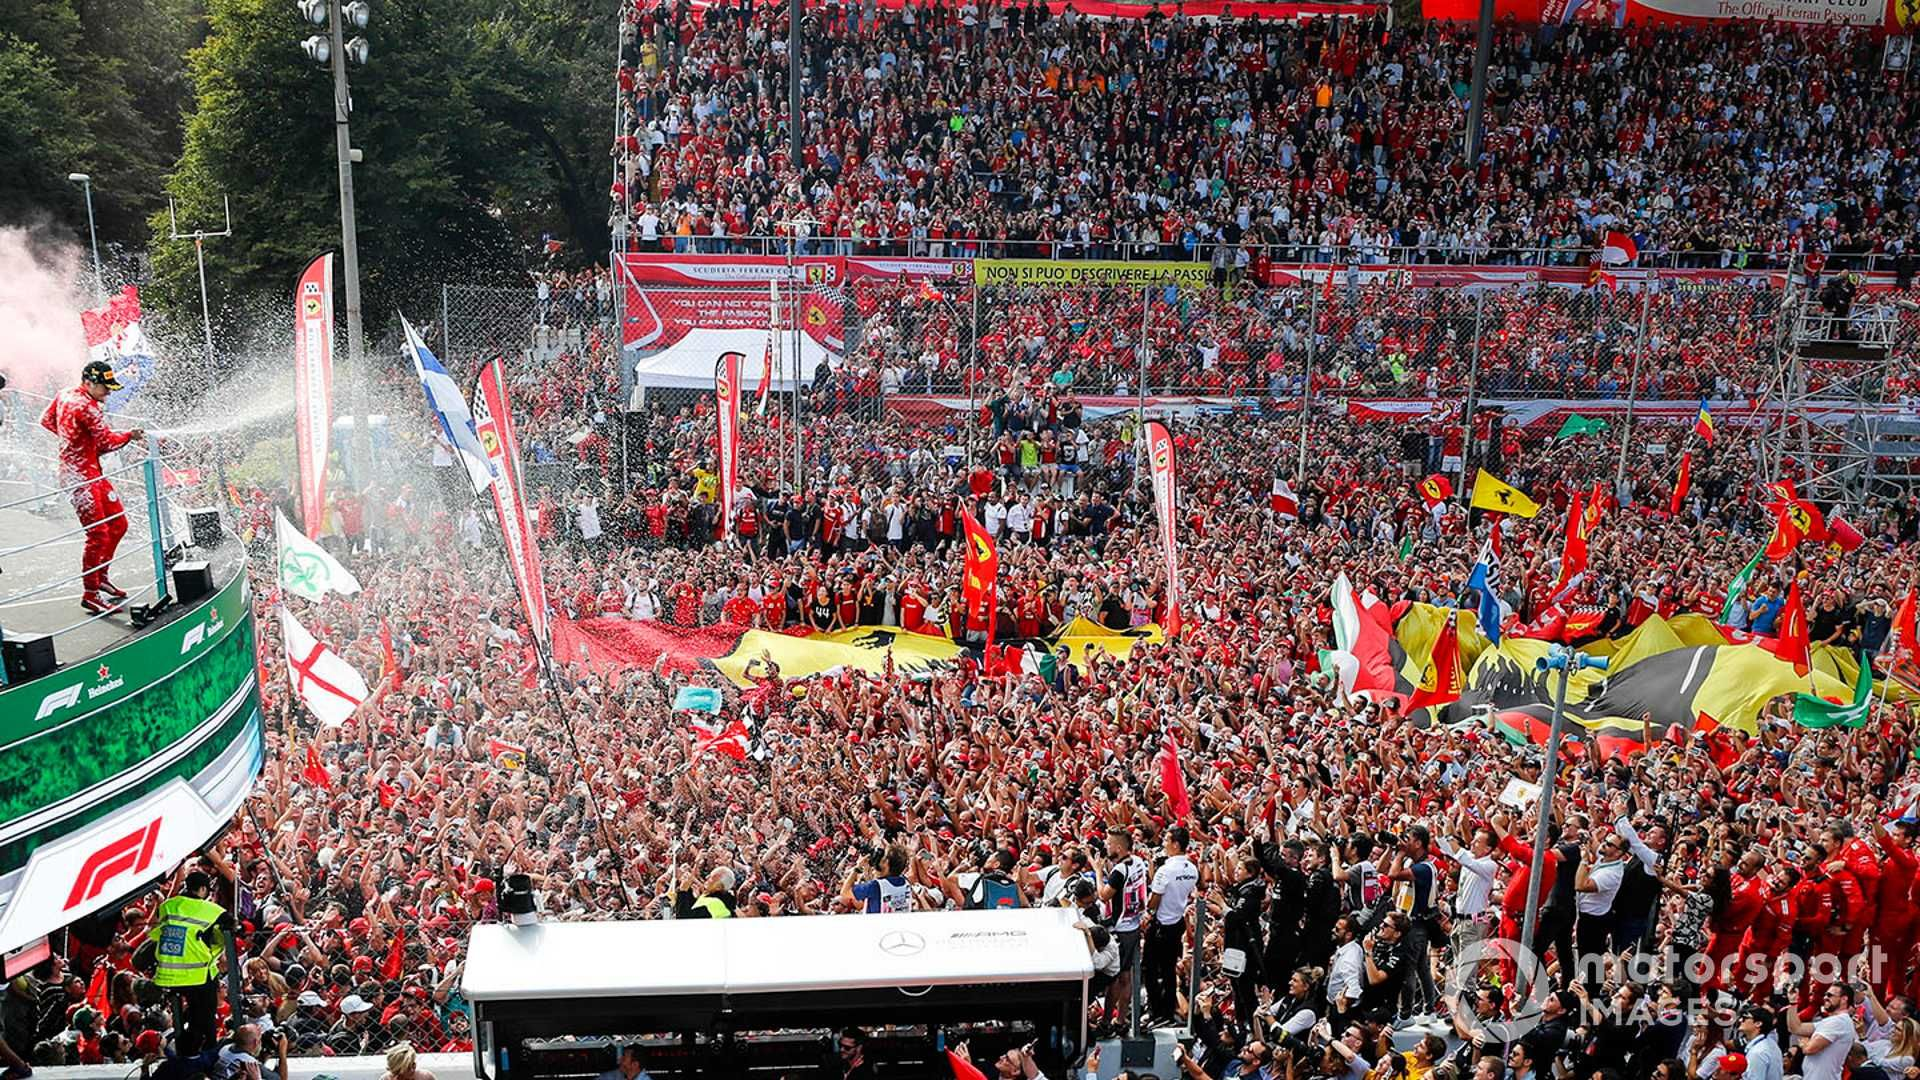

Le dataset ne nous fournit pas la puissance de la voiture, cette donnée n'étant pas quantifiable (mis à part peut-être la puissance du moteur). Nous devons donc essayer nous-même de quantifier ce paramètre.

Dans le paddock, les deux ou trois écuries dominatrices arrivent à réaliser des tours souvent plus d'une seconde plus rapide que les écuries de milieu de plateau et les <i>backmarkers</i> : on cherche donc un coefficient $\mu_x$ permettant de modéliser cette disparité. Nous choisirons $\mu_x = \frac{1}{tan(0.1x)^{0.7}}$, avec $x$ la position au championnat constructeurs de l'année précédente.

Bien entendu, les avancées technologiques d'une écurie ne se conservent pas toujours d'une année sur l'autre : un exemple flagrant en est l'écurie Brawn GP, victorieuse en 2009 grâce à un système à la légalité douteuse mais seulement 4e en 2010, sous l'égide de leur acquéreur Mercedes. Ainsi, on introduit un deuxième coefficient, que nous appellerons coefficient de forme, qui reprend l'équation du coefficient de puissance en remplacant $x$ par la position actuelle au championnat constructeur : ce coefficient progresse donc au fur et à mesure de la saison.

In [ ]:
def prepareDataset(raceId):
    '''
    TODO: Essayer de rendre la fonction plus rapide (objectif : préparer les datasets pour toutes les courses
          en moins de 10 secondes)
    Cette fonction renvoie, pour une course, les résultats de cette course agrémentés pour chaque ligne
    des coefficients de puissance et de forme du constructeur associé
    In : raceId (int)
    Out : Les résultats de la course (DataFrame)
    '''
    result = results[results['raceId'] == raceId]
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    result['constructorPower'] = result['constructorId'].apply(lambda x: 1.0/np.power(np.tan(0.1*getWCCResult(year-1,x)),0.7))
    result['constructorForm'] = result['constructorId'].apply(lambda x: 1.0/np.power(np.tan(0.1*getWCCPosition(year,current_round,x)),0.7))
    result = result[['driverId','constructorId','grid','positionOrder','points','statusId','constructorPower','constructorForm']].sort_values('grid')
    return result

In [ ]:
'''
On prépare le dataset pour toutes les courses de la base
ATTENTION : FONCTION LENTE A L'EXECUTION
'''
my_dataset = prepareDataset(1)
print(races.shape[0])
for i in range(2, races.shape[0]/2):
    print("{}/{}\r".format(i,races.shape[0]/2)),
    my_dataset = my_dataset.append(prepareDataset(i))
    
display(my_dataset)

In [ ]:
my_dataset.describe()
'''
On garde uniquement les pilotes qui ont terminé la course
Status 1 : fini la course
Status 11 : +1 Lap
Status 12 : +2 Laps
'''
my_dataset = my_dataset[(my_dataset['statusId'] == 1) | (my_dataset['statusId'] == 11) | (my_dataset['statusId'] == 12)]
#On garde uniquement les colonnes qui nous intéressent.
my_dataset = my_dataset[['grid','positionOrder','constructorPower','constructorForm']]
#On mélange le dataset
my_dataset = my_dataset.reindex(np.random.permutation(my_dataset.index))

Traçons quelques graphiques pour visualiser la distribution de nos données.

- Sur le premier graphique, on voit qu'il y a une très forte corrélation entre la position sur la grille et la position à l'arrivée.

- Sur les deuxième et troisième graphes, on remarque la corrélation entre les coefficients de puissance et de forme et la position à l'arrivée.

In [ ]:
sns.jointplot(my_dataset['grid'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position de depart")

sns.jointplot(my_dataset['constructorPower'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position au championnat n-1")

sns.jointplot(my_dataset['constructorForm'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position au championnat")

In [ ]:
#Afin d'être sûrs, on retire les valeurs nulles
my_dataset = my_dataset.dropna()

#On crée les ensembles d'entraînement et de test.
train_dataset = my_dataset.sample(frac=0.8,random_state=1)
test_dataset = my_dataset.drop(train_dataset.index)

#C'est une manière de récupérer la moyenne et l'écart-type de chaque colonne.
train_stats = train_dataset.describe()
train_stats.pop("positionOrder")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('positionOrder')
test_labels = test_dataset.pop('positionOrder')

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

display(normed_test_data.head(20))

### Création du modèle avec TensorFlow

Typiquement, TensorFlow permet d'obtenir une bonne précision sur les résultats si on sait ce qu'on fait.
Nous allons créer et entraîner un modèle TensorFlow puis comparer ses prédictions avec notre propre modèle.

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()

In [ ]:
EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)
test_predictions = model.predict(normed_test_data).flatten()


In [ ]:
sns.jointplot(test_labels, test_predictions, kind='hex')
plt.suptitle('Valeurs predites par TensorFlow contre vraies valeurs')

In [ ]:
TFError = test_predictions - test_labels
fig, ax = plt.subplots(1,1)
plt.hist(TFError, bins = 20, color='gold',alpha=0.9)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)

plt.xlabel("Erreur sur la prediction avec TensorFlow")
_ = plt.ylabel("Nombre")

Qu'observe-t-on ? On voit que la prédiction a fonctionné, l'algorithme arrive à trouver la position du pilote.

### Création du modèle à la main

Ici, nous allons coder à la main une fonction de descente de gradient dans le but de créer un modèle de régression linéaire pour prédire la position à l'arrivée d'un pilote.
L'objectif est de pouvoir faire tourner l'algorithme plus rapidement que Lance Stroll.

In [ ]:
def loss(predicted_labels,labels):
    '''
    Cette fonction de perte renvoie la MSE (Mean Square Error)
    '''
    m = len(labels)
    mySum = 0
    for i in range(0,len(labels)-1):
        mySum += np.power((predicted_labels[i]-labels[i]),2)
    mySum = (1.0/m)*mySum
    return np.sqrt(mySum)


def gradient_descent(data,weights,labels,speed=0.05,niter=100,tol=0.00001,i=0):
    '''
    Weights est un vecteur n colonnes, data est une matrice m lignes n colonnes, les prédictions sont un vecteur m colonnes
    '''
    prediction = np.dot(data,weights)
    coeff = (1.0*speed)/data.shape[0]
    lossIter = loss(prediction,labels)
    for j in range(0,(weights.shape[0])):
        time.sleep(0.01)
        myLoss = 0
        for k in range(0,data.shape[0]):
            myLoss += (prediction[k]-labels[k])*data[k][j]
        print('Itération {}, weights[0] = {}, weights[1] = {}, le cout est de {}\r'.format(i,weights[0],weights[1],myLoss)),
        weights[j] = (weights[j]-(1.0*coeff*myLoss))
    if lossIter < tol or i >= niter:
        return weights
    hist.append(lossIter)
    #Fonction récursive, ce n'est peut-être pas la manière la plus élégante de le faire.
    return gradient_descent(data,weights,labels,speed,niter,tol,i+1)

def predict(data,weights):
    return np.dot(data,weights)

hist = []
train = train_dataset.to_numpy()
lab = train_labels.to_numpy()
test = test_dataset.to_numpy()
test_lab = test_labels.to_numpy()
print(train.shape[1])
my_weights = gradient_descent(train,np.random.rand(train.shape[1]),lab,speed=0.01, niter=150)
my_test = predict(test,my_weights)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(111)
l1, = ax3.plot(np.arange(len(hist)), hist, 'red')
plt.suptitle('Evolution de la RMSE en fonction des iterations')
plt.yscale('log')

In [ ]:
myplot = sns.jointplot(my_test, test_lab,kind='hex')
plt.suptitle("Valeurs predites contre vraies valeurs")

In [ ]:
error = my_test - test_lab
fig, ax = plt.subplots(1,1)
plt.hist(error, bins = 20, color='gold',alpha=0.9)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)
plt.xlabel("Erreur sur la prediction")
_ = plt.ylabel("Nombre")

On peut remarquer que l'algorithme de descente de gradient ne présente pas d'overfitting et prédit plutôt bien la position d'arrivée du pilote, même si l'algorithme de TensorFlow est légèrement plus performant.

In [ ]:
fig = plt.figure(figsize=(14,5),dpi=300)
ax2 = fig.add_subplot(121)
ax2.hist(error, bins = 20, color='blue',alpha=0.5)
ax2.set_ylabel('Nombre de predictions')
ax2.set_xlabel('Erreur (en nombre de positions)')
ax2.set_facecolor('xkcd:white')
plt.xlim(-10,10)
ax2.legend()
ax2.grid(False)
ax2.title.set_text('Descente de gradient')
     
ax1 = fig.add_subplot(122)
ax1.hist(TFError, bins = 20, color='red',alpha=0.5)
ax1.title.set_text('TensorFlow')
ax1.set_facecolor('xkcd:white')
plt.xlim(-10,10)
ax1.set_xlabel('Erreur (en nombre de positions)')
ax1.grid(False)
plt.tight_layout()

## Remplissage du dataset des pit-stops

Le dataset que nous utilisons est incomplet : en effet, il ne propose les informations de pit-stop qu'à partir de la 841e course, alors que les données des temps au tour sont disponibles pour beaucoup plus de courses. Nous souhaitons remplir ce dataset.

On remarque qu'un pit-stop est symbolisé sur le graphique des temps au tour par un pic brusque entre deux tours rapides. Il est donc possible d'utiliser un algorithme d'apprentissage supervisé pour trouver les pit-stops à chaque course.

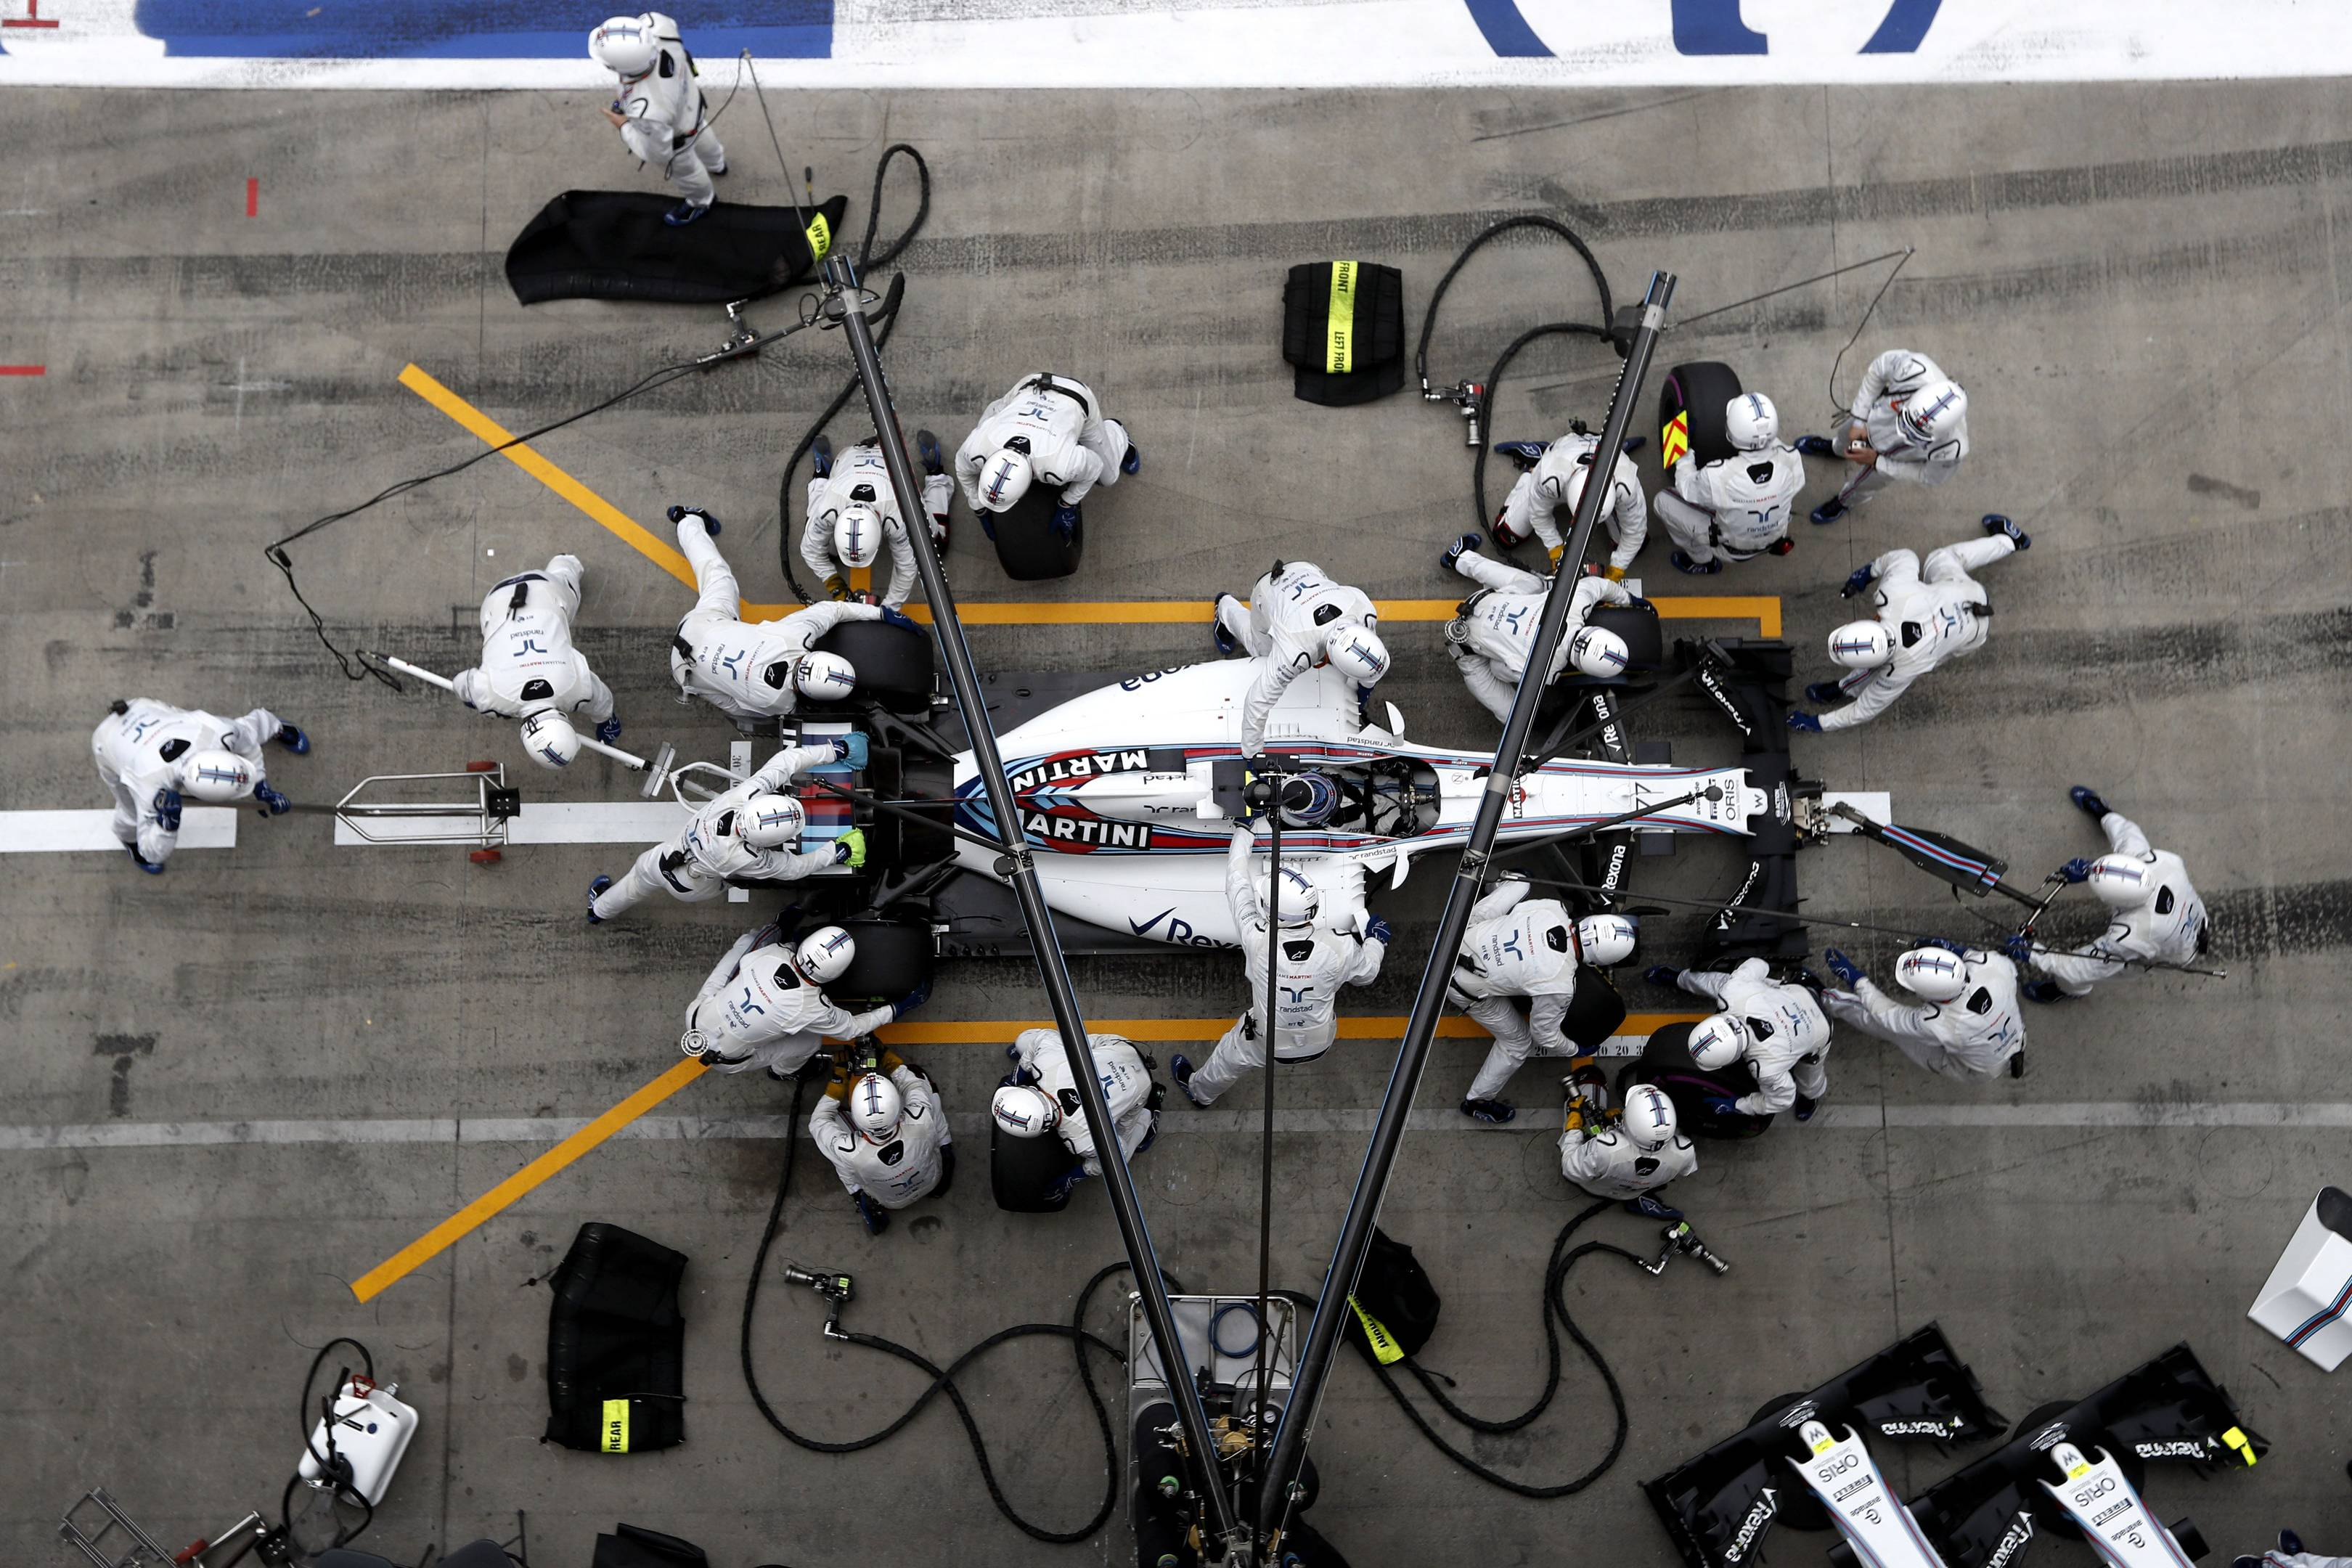

In [ ]:
'''
On tente de séparer les courses en fonction de si les informations de pit-stops sont remplies.
Il faut trouver une manière de vectoriser cette opération car c'est très long d'essayer d'itérer sur les lignes 
d'un DataFrame de grande taille.
'''

racesWithPitInformation = races
racesWithoutPitInformation = races.iloc[0:0]
j=0
# for index, row in races.iterrows():
#     if pitStops[pitStops['raceId'] == index].empty:
#         racesWithPitInformation = racesWithPitInformation.drop(index)
#         racesWithoutPitInformation = racesWithoutPitInformation.append(row)

Préparation des sets : on va avoir un training set d'environ beaucoup d'exemples. On peut essayer d'appliquer la technique de cross-validation pour entraîner le modèle. <br>
Quelles sont les features ? 
<ul>
    <li>driverId</li>
    <li>circuitId</li>
    <li>lap</li>
    <li>milliseconds</li>
</ul>
Le label est un vecteur y de taille $m = nbLaps$.
Si le pilote a réalisé un pit-stop aux tours 4 et 8, on aura $y=[0,0,0,1,0,0,0,1,0,...,0]$

In [ ]:
# display(racesWithPitInformation.head())
# display(lapTimes.head())

datasetPit = lapTimes.merge(racesWithPitInformation, on='raceId')
datasetPit = datasetPit[['raceId','driverId','lap','milliseconds','circuitId']]
datasetPit = datasetPit[datasetPit['lap'] > 5]
# for index,row in datasetPit.iterrows():
#     if not pitStops[(pitStops['driverId'] == row['driverId']) & (pitStops['raceId'] == row['raceId']) & (pitStops['lap'] == row['lap'])].empty:
#         print(index)
#         datasetPit['pit'].iloc[index] = 1
display(datasetPit.head(10))

In [ ]:
#dataset_pit.csv a été généré par moi, il contient les courses dont on connaît les informations de pit
my_dataset = pd.read_csv('dataset_pit.csv', index_col=0)
#En raison d'incidents pouvant survenir en début de course, on a beaucoup de pits dans les premiers tours
#Ils créent un bruit inutile et peuvent rendre la prédiction moins précise
#On retire donc les informations de tour avant le 5e tour.
my_dataset = my_dataset[my_dataset['lap'] > 5]

#On va créer une colonne contenant le temps du tour précédent
my_dataset['previousLap'] = np.zeros(my_dataset.shape[0])

#Pour ce faire, on effectue une translation du dataset dans une copie.
my_dataset_trans = my_dataset.shift(1)

#On duplique la première ligne pour qu'elle ne soit pas vide
my_dataset_trans.iloc[0] = my_dataset.iloc[0]

#On associe les deux champs. On rajoute raceId et driverId pour que le tour précédent corresponde bien au bon pilote.
my_dataset['previousLap'] = my_dataset_trans['milliseconds']
my_dataset['previousLapRaceId'] = my_dataset_trans['raceId']
my_dataset['previousLapDriverId'] = my_dataset_trans['driverId']
my_dataset['previousLapPit'] = my_dataset_trans['pit']

#Le rapport du temps au tour actuel et du temps au tour précédent.
my_dataset['previousLapDelta'] = np.where((my_dataset['raceId'] == my_dataset['previousLapRaceId']) & (my_dataset['driverId'] == my_dataset['previousLapDriverId']) & my_dataset['previousLapPit'] != 1, my_dataset['milliseconds']/my_dataset['previousLap'], 1)

#On répète exactement la même opération pour le tour suivant
my_dataset_fwd = my_dataset.shift(-1)
my_dataset_fwd.loc[my_dataset_fwd.shape[0]] =  my_dataset.loc[my_dataset.shape[0]]
my_dataset['nextLap'] = my_dataset_fwd['milliseconds']
my_dataset['nextLapRaceId'] = my_dataset_fwd['raceId']
my_dataset['nextLapDriverId'] = my_dataset_fwd['driverId']
my_dataset['nextLapPit'] = my_dataset_fwd['pit']
my_dataset['nextLapDelta'] = np.where((my_dataset['raceId'] == my_dataset['nextLapRaceId']) & (my_dataset['driverId'] == my_dataset['nextLapDriverId']) & my_dataset['nextLapPit'] != 1, (my_dataset['milliseconds']/my_dataset['nextLap']), 1)

#lapDelta correspond à la différence du tour actuel par rapport au précédent ET au suivant
my_dataset['lapDelta'] = (my_dataset['previousLapDelta']+my_dataset['nextLapDelta'])/2

#On accentue les résultats : si lapDelta ~ 1 alors on affecte une valeur 1-exp(1-1) ~ 0 
#                            si lapDelta >> 1 alors on affecte une valeur 10*(1-exp(1-1,5)) >~ 1
my_dataset['lapDelta'] = my_dataset['lapDelta'].apply(lambda x: 10.0*(1-np.exp(1-x)))

#On centre les résultats (attention : l'algorithme fonctionne mieux si on ne le fait pas)
# my_dataset['lapDelta'] = (my_dataset['lapDelta']-my_dataset['lapDelta'].mean())/my_dataset['lapDelta'].std()

#Si la valeur est plus petite que 0,05 on affecte 0, sinon on multiplie par 10
#"Feature engineering at its finest"
my_dataset['lapDelta'] = np.where((np.abs(my_dataset['lapDelta']) < 0.05) | (my_dataset['pit'] == 0),0,10*my_dataset['lapDelta'])

#On retire les colonnes dont on n'a pas besoin
my_dataset = my_dataset.drop(['previousLap','previousLapRaceId','previousLapDriverId','nextLap','nextLapRaceId','nextLapDriverId'],axis=1)

#On retire les 50 valeurs les plus grandes qui peuvent empêcher un apprentissage de qualité ta3 Montessori
for i in range(1,50):
    my_dataset = my_dataset.drop(my_dataset['previousLapDelta'].idxmax())
    my_dataset = my_dataset.drop(my_dataset['nextLapDelta'].idxmax())

#On affiche le dataset préparé.    
display(my_dataset.head(10))

On peut transformer le problème en un problème de régression logistique : <b>A un tour donné, quelle est la probablilité qu'un pilote réalise un arrêt au stand ?

On peut remarquer ici que seuls 4% des labels représentent un arrêt au stand : les données ne sont pas du tout équitablement réparties !!

In [ ]:
neg, pos = np.bincount(my_dataset['pit'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({}% of total)\n'.format(
    total, pos, 100 * pos / total))

On crée les ensembles d'entraînement, de validation et de test.

In [ ]:
#On tente de prédire avec une seule feature mais qui est la combinaison de plusieurs autres
cleaned_df = my_dataset[['lapDelta','pit']]

#On retire les valeurs nulles
cleaned_df = cleaned_df.dropna()

#On utilise une fonction de sklearn pour créer les ensembles d'entraînement et de test.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#On extrait les labels et les données
train_labels = np.array(train_df.pop('pit'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('pit'))
test_labels = np.array(test_df.pop('pit'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

#On sépare le dataset pour pouvoir affecter des poids de classe : ceci est important pour contrebalancer
#le fait que les classes sont inéquitablement réparties
"""ATTENTION : PAS ENCORE IMPLEMENTE DANS L'ALGORITHME DE REGRESSION"""
pit_y = cleaned_df[cleaned_df['pit'] == 1]
pit_n = cleaned_df[cleaned_df['pit'] == 0]
neg = pit_n["pit"].count()
pos = pit_y['pit'].count()
total = neg+pos
display(pit_y.describe())
display(pit_n.describe())
#On divise par 2 pour garder la perte dans le même ordre de grandeur
weight_for_0 = (1.0 / neg)*(total)/2.0 
weight_for_1 = (1.0 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
def sigmoid(x):
    '''
    Retourne la fonction sigmoide qui nous permet d'exprimer une probabilité entre 0 et 1
    '''
    return 1.0/(1+np.exp(-x))

def propagate(w, b, X, Y):
    '''
    In : w (numpy array) de dimension (n,1) : les poids affectés aux données
         b (numpy array) de dimension (1,m) : le biais
         X (numpy array) de dimension (n,m) : les données avec n features et m examples
         Y (numpy array) de dimension (1,m) : les labels
    Out : grads {dw : np.array(n,1), db = np.array(1,m)} : dictionnaire avec la dérivée de w et b pour pouvoir mettre à jour les poids
          cost (float) : le coût
    '''
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X)+b)
    cost = (-1.0/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    dw = (1.0/m)*np.dot(X,(A-Y).T)
    db = (1.0/m)*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    '''
    Boucle principale de l'algorithme
    In : w (numpy array) de dimension (n,1) : les poids affectés aux données
         b (numpy array) de dimension (1,m) : le biais
         X (numpy array) de dimension (n,m) : les données avec n features et m examples
         Y (numpy array) de dimension (1,m) : les labels
         num_interations (int) : nombre d'itérations de l'algorithme
         learning_rate (float) : vitesse de convergence
         print_cost (bool) : afficher ou pas le coût
    Out : params {w: np.array(n,1), b: np.array(1,m)} : les poids et le biais
          grads {dw: np.array(n,1), db: np.array(1,m)} : les dérivées des poids et du biais
          costs (list(float)) : l'historique des coûts
    '''
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate*dw
        b = b - learning_rate*db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost:
            print ("Cost after iteration %i: %f\r" %(i, cost)),
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

def predict(w, b, X):
    '''
    In : w (numpy array) de dimension (n,1) : les poids affectés aux données
         b (numpy array) de dimension (1,m) : le biais
         X (numpy array) de dimension (n,m) : les données avec n features et m examples
    Out : Y_prediction (numpy array) de dimension (1,m) : les labels prédits par l'algorithme
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T,X)+b)
    for i in range(A.shape[1]):
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    '''
    Création du modèle : on entraîne sur le training test et on teste sur le test set (bah ouais logique)
    Retourne un dictionnaire avec toutes les informations
    '''
    w, b = np.zeros((X_train.shape[0],1)),0
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations=num_iterations,learning_rate=learning_rate,print_cost=print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    print("\ntrain accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [ ]:
d = model(train_features.T, train_labels, test_features.T, test_labels, num_iterations = 2000, learning_rate = 0.05, print_cost = True)

In [ ]:
#On récupère l'historique des coûts
costH = d['costs']
#On récupère les prédictions
predictions = d['Y_prediction_test']
test_labels = np.transpose(test_labels)
# print(predictions.tolist())
print(np.sum(predictions))
print(test_labels.shape)

On affiche la matrice de confusion

**TODO : Coder la matrice à la main**

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Vrai label')
    plt.xlabel('Label predit')

plot_cm(test_labels[0], predictions[0])

In [ ]:
my_test = np.where(my_test <= 0.5,0,1)
cm = confusion_matrix(test_labels[0], predictions[0] > 0.5)
TP = cm[1][1] #Vrais positifs
TN = cm[0][0] #Vrais négatifs
FP = cm[0][1] #Faux positifs
FN = cm[1][0] #Faux négatifs
precision = 1.0*TP/(TP+FP)
recall = 1.0*TP/(TP+FN)
accuracy = (1.0*TP+TN)/(TP+TN+FP+FN)
f1 = 2.0*(1.0*precision*recall)/(1.0*precision - recall)
tfp = 1.0*FP/(1.0*FP+TN)
print("Précision : {}".format(precision))
print("Recall : {}".format(recall))
print("Accuracy : {}".format(accuracy))
print("Score F1 : {}".format(f1))

Que remarque-t-on ?
On voit que la précision vaut 1, ce qui signifie que nous n'avons pas prédit de pit-stop alors qu'il n'y en avait pas. Ceci est de bon augure.
Cependant, le rappel est proche de 0, ce qui signifie que nous avons manqué beaucoup de prédictions.
Il faut donc améliorer l'algorithme

In [ ]:
plt.plot(costH)
plt.suptitle('Evolution du cout en fonction des iterations')

_Texte à écrire quand on aura vraiment réussi la régression logistique_

En observant la matrice de confusion, on voit que l'algorithme prodigue un très grand nombre de VN (vrais négatifs) et un nombre raisonnable de VP (vrais positifs), alors qu'il n'a pas une seule fois prédit un pit-stop alors qu'il n'y en avait pas. 

<b>Nous avons réussi à déterminer si un pilote effectue un pit-stop !</b>

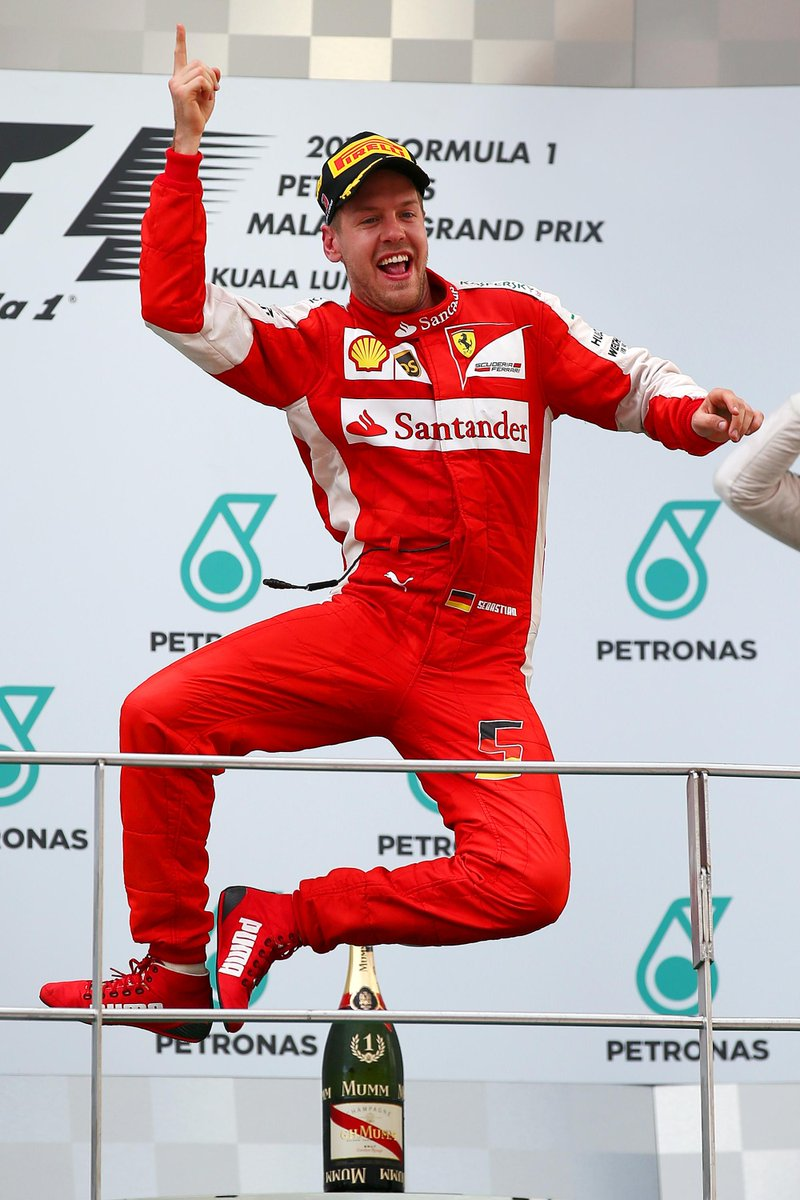

## Création d'un classificateur pour déterminer le type de pneu utilisé pendant un relais
En Formule 1, cinq types de pneus peuvent être utilisés pendant une course : 
<ul>
    <li> Soft : ce pneu, extrêmement rapide, possède la durée de vie la plus courte.</li>
    <li> Medium : ce pneu est moyennement rapide et possède une durée de vie moyenne.</li>
    <li> Hard : ce pneu est le plus lent mais le plus durable.</li>
    <li> Inter : ce pneu est conçu pour être utilisé sur circuit humide.</li>
    <li> Wet : ce pneu est utilisé dans le cas d'un circuit trempé, c'est le plus lent de tous.</li>
</ul>
Nous n'avons pas de labels à notre disposition pour entraîner un modèle de manière supervisée. Il s'agit d'un problème <b>d'apprentissage non supervisé</b>.

Il est raisonnable de penser que réussir à classifier les pneus dans ce scénario est hors de portée pour des étudiants de L3 : nous allons donc utiliser un ensemble d'apprentissage très restreint, ne contenant que les données de pneus pour une saison, recueillies à la main.

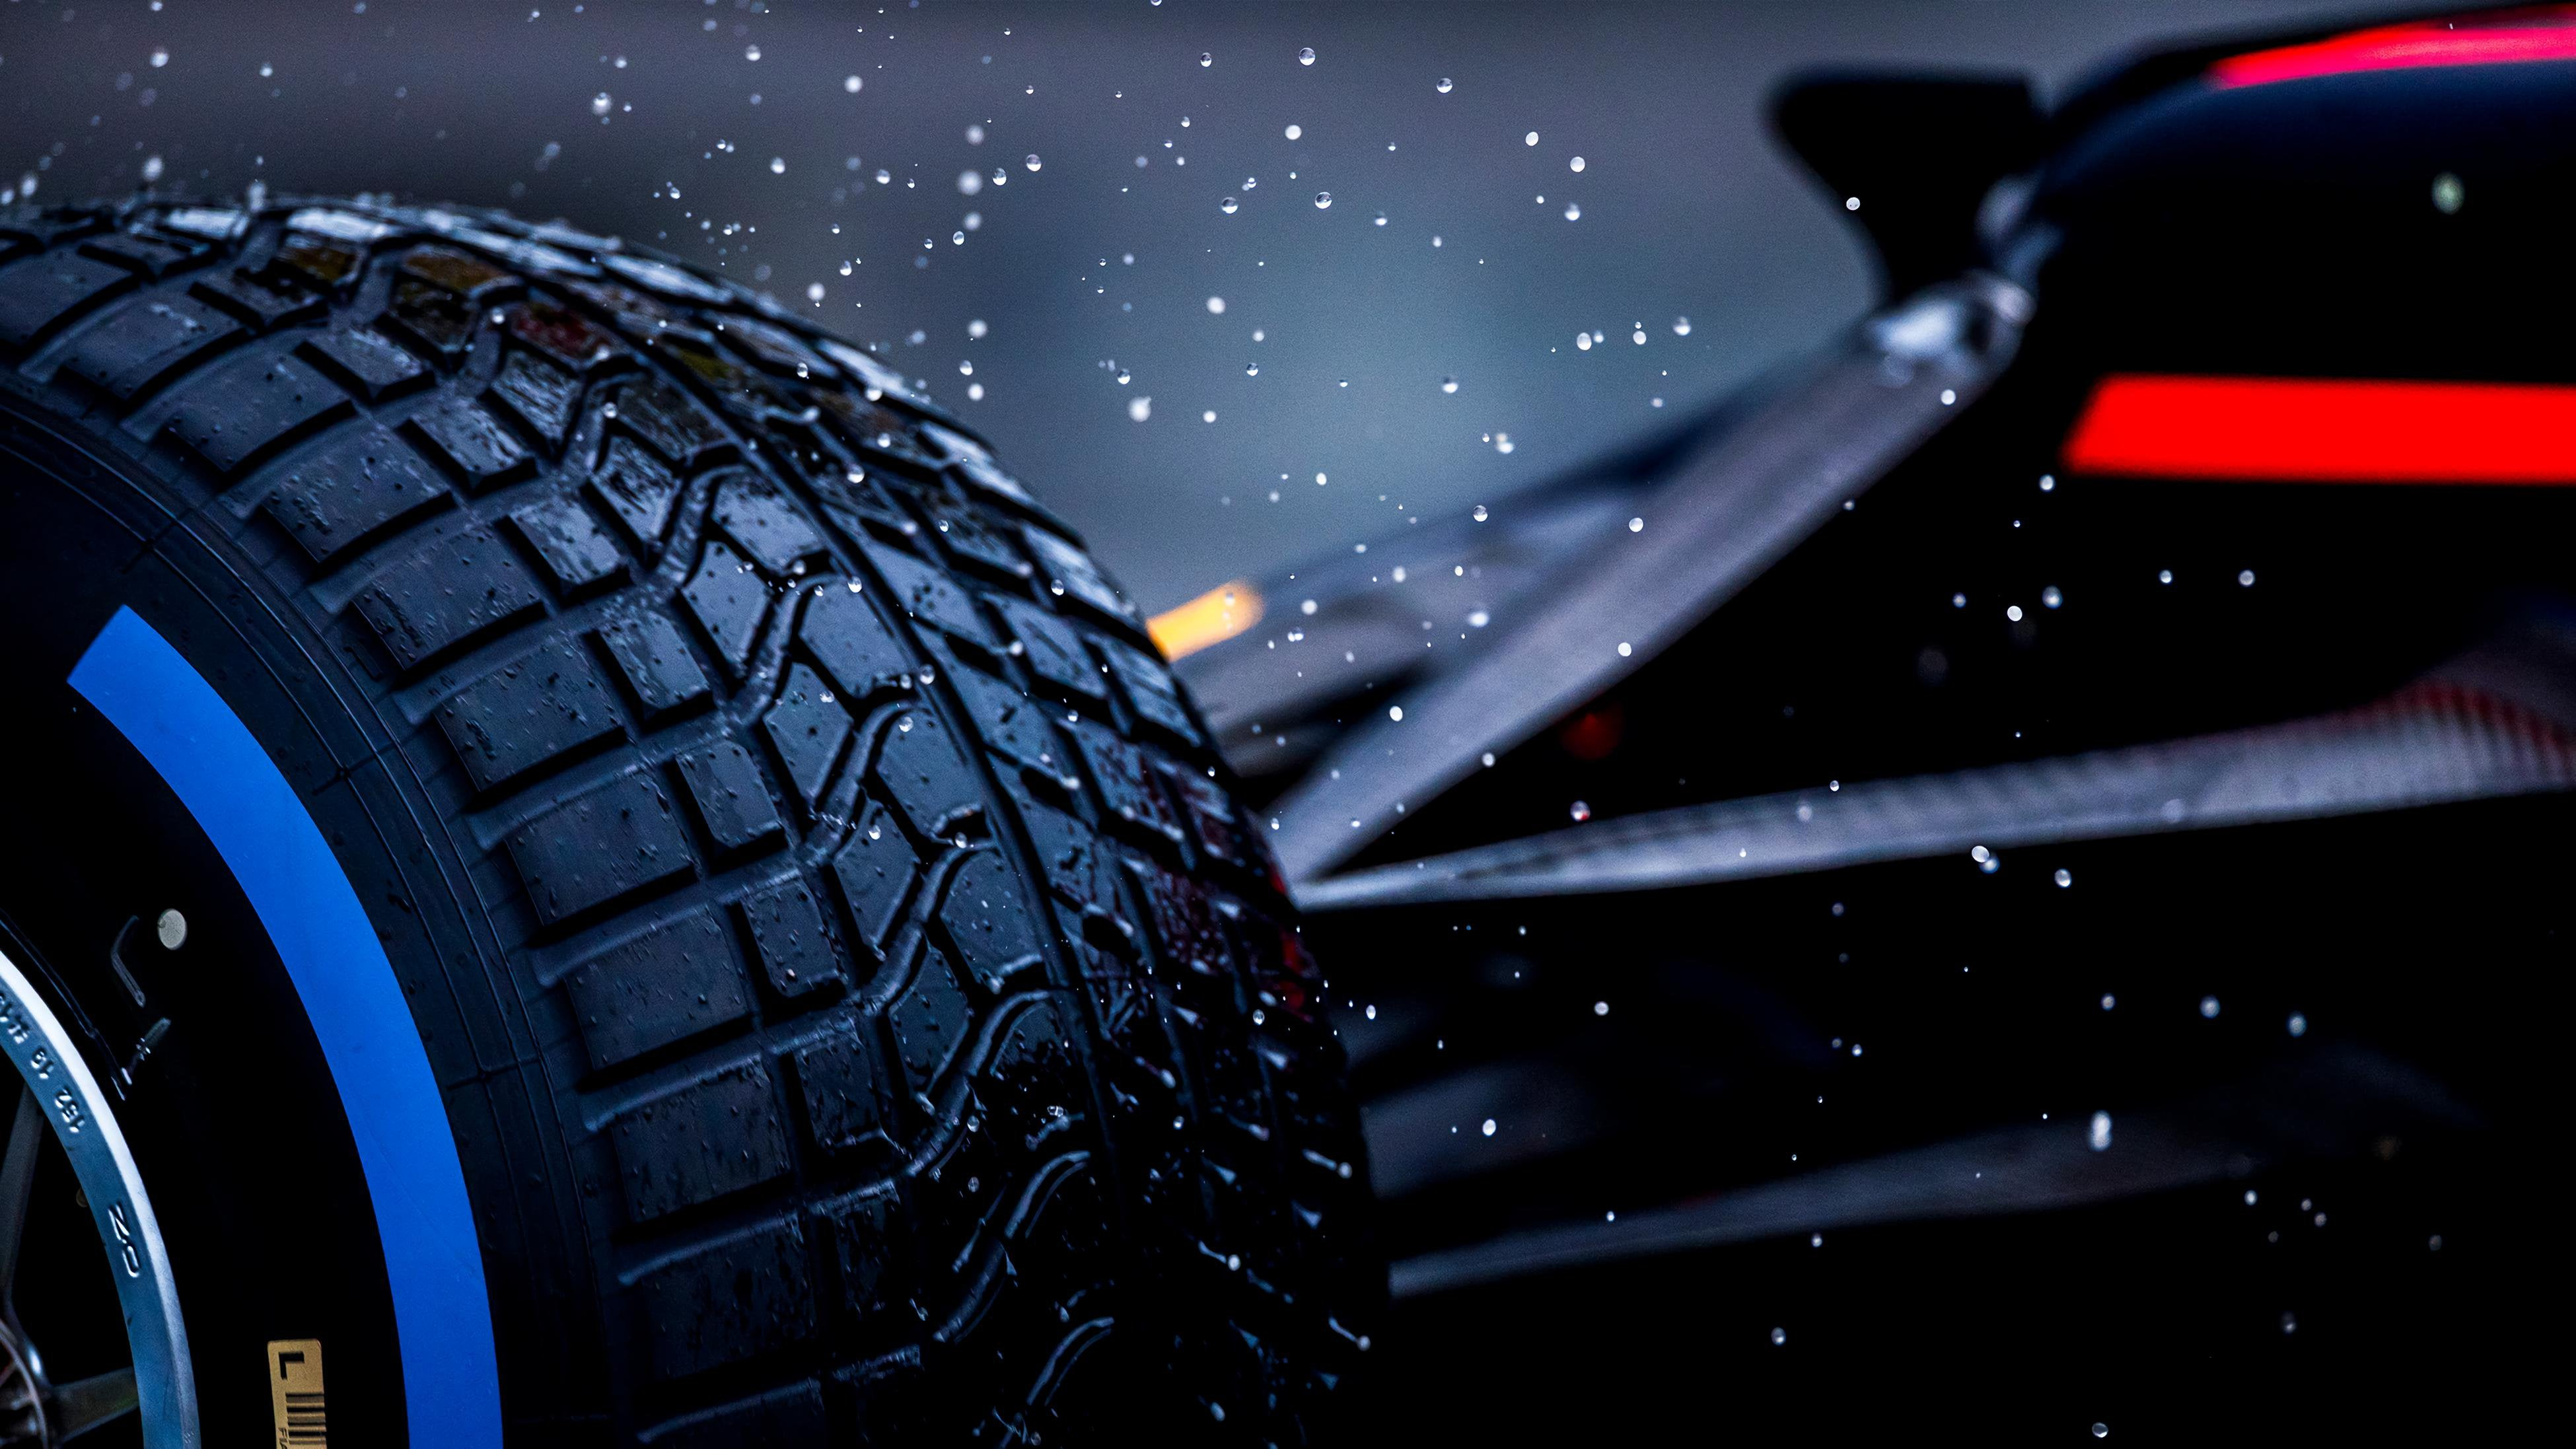

<a href="https://f1metrics.wordpress.com/2014/06/04/who-was-the-best-wet-weather-driver/#bottom">Ce lien recense toutes les courses de Formule 1 qui se sont déroulées sous la pluie</a><br>
Il est possible d'utiliser ces données pour classifier : en effet, si une course ne s'est pas déroulée par temps pluvieux, alors on peut disqualifier d'office les pneux <i>Inter</i> et <i>Wet</i>.

### Intuitions pour développer le modèle

L'objectif est de trouver, pendant une course et pour un pilote donné, quels composés de pneus il a utilisé.
La différence entre deux composés de pneus peut être observée sur deux plans : la durée du relais (longévité du pneu) et le temps au tour (adhérence du pneu).

Il convient de prendre en compte les considérations suivantes : 

- Un pilote Williams ayant chaussé des <i>softs</i> peut avoir, au même moment de la course, un temps au tour supérieur à un pilote Ferrari équipé de <i>hards</i> en raison de la différence de puissance entre les deux monoplaces. Pour modéliser ce phénomène, on peut réutiliser les coefficients de puissance et de forme introduits dans la partie régression linéaire de ce projet.

- Au fur et à mesure de l'avancement de la course, les voitures s'allègent en raison de la diminution de la masse d'essence dans le réservoir : c'est pourquoi le <i>Meilleur tour</i> est très souvent obtenu en fin de course : on peut donc prendre en compte le nombre de tours, sous forme de pourcentage, pour classifier pneus.

- Naturellement,un temps au tour ne peut être représentatif que pour un circuit donné : c'est pour cela qu'il conviendra de stocker l'identifiant du circuit sous forme de one-hot.

Notre dataset sera de la forme suivante:

| circuitId | constructorPower | constructorForm | race_completion | stint_duration | stint_avg_laptime | compound |

En fait l'histoire est plus complexe : Pirelli, le fabricant de pneus officiel de la Formule 1, propose une gamme de 5 composés de pneus pour la saison. Ils possèdent chacun un identifiant, qui s'étend de C1 (gomme la plus dure) à C5 (gomme la plus molle).

Chaque weekend, trois composés sont sélectionnés parmi les 5 disponibles et sont affublés des noms <i>soft, medium et hard</i>. Ainsi, si le choix de pneus est $(C1,C2,C3)$ pour un weekend $w_1$ et $(C3,C4,C5)$ pour un weekend $w_2$, le pneu _soft_ de $w_1$ est exactement le même composé que le _hard_ de $w_2$ !

C'est pourquoi nous devrons associer, pour chaque course, aux pneus leur composé exact et procéder à une classification en cinq classses et non pas trois comme l'intuition nous le suggèrerait.

In [ ]:
'''
Ce dictionnaire associe à chaque course de la saison 2019 le choix de pneus effectué par 
Pirelli (données recueillies à la main).


================================================================
UPDATE 16 AVRIL : LE MODELE FONCTIONNE MIEUX AVEC LES 5 COMPOSES 
================================================================


On remarque que la classification en prenant en compte les 5 composés marche moins bien qu'en gardant 
un modèle simple à trois composés.
Il faut donc soit améliorer le modèle soit repasser à 3 composés (soft, medium, hard)
'''
tyre_compound_selection = {1010:[4,3,2], #Australia
                           1011:[3,2,1], #Bahrain
                           1012:[4,3,2], #China
                           1013:[4,3,2], #Azerbaijan
                           1014:[3,2,1], #Spain
                           1015:[5,4,3], #Monaco
                           1016:[5,4,3], #Canada
                           1017:[4,3,2], #France
                           1018:[4,3,2], #Austria
                           1019:[3,2,1], #Great Britain
                           1020:[4,3,2], #Germany (cette course s'est déroulée sous la pluie)
                           1021:[4,3,2], #Hungary
                           1022:[3,2,1], #Belgium
                           1023:[4,3,2], #Italia
                           1024:[5,4,3], #Singapore
                           1025:[4,3,2], #Russia
                           1026:[3,2,1], #Japan
                           1027:[4,3,2], #Mexico
                           1028:[4,3,2], #USA
                           1029:[3,2,1], #Brazil
                           1030:[5,4,3], #Abu Dhabi
                          }

In [ ]:
def getStints(raceId,driverId):
    '''
    Cette fonction donne les différents relais effectués par un pilote pendant une course (tous deux
    passés en paramètre).
    L'intuition nous suggère de prendre, pour chaque relais, la moyenne du temps au tour.
    Plutôt , on prend le tour le plus rapide de ce pilote en qualifications (donc sur le pneu le plus tendre).
    Cela nous permet de retirer l'aspect de différence de puissance entre les voitures puisqu'on compare un pilote 
    avec sa propre performance.
    In : raceId (int)
         driverId (int)
    Out : stintDf (DataFrame) qui comporte les features de chaque relais pour ce pilote.
    '''
    #On crée le DataFrame qu'on va retourner
    stintDf = pd.DataFrame(columns=['circuitId','driverId','constructorId', 'constructorPower','constructorForm', 'race_completion', 'stint_duration','stint_avg_laptime','compound'])
    
    #On récupère les informations de course
    (race,driver,result,pits,quali,laps) = getInformation(raceId, driverId)
    
    #On récupère le composé de pneus de cette course pour le pilote
    tyre = tyres[(tyres['raceId'] == raceId) & (tyres['driverId'] == driverId)]
    
    #On récupère l'année, le constructeur, le circuit, le round, 
    #le tour le plus rapide en qualifications et en course
    year = race['year']
    current_round = race['round']
    qualifyingTimes = getQualifyingTime(raceId, driverId)
    fastestLap = getFastestLapTime(raceId)
    circuit = int(race['circuitId'])
    constructor = int(result['constructorId'])
    
    #On associe à chaque tour son rapport avec le temps de qualifications.
    #Le modèle marche moins bien si on fait cela, donc on ne l'utilise pas pour l'instant.
#     laps['milliseconds'] = laps['milliseconds']/qualifyingTimes
    
    #On crée les coefficients de forme et de puissance.
    power = 1.0/np.power(np.tan(0.1*getWCCResult(year-1,result['constructorId'])),0.7)
    form = 1.0/np.power(np.tan(0.1*getWCCPosition(year,current_round,result['constructorId'])),0.7)
    
    #On retrouve les informations de pit-stop
    race_duration = laps.shape[0]
    pit_laps = pits['lap']
    nb_pits = 0
    laps2 = {0:[]}
    stints = {0:[]}
    for i in range(1,race_duration):
        try:
            if i < pit_laps.iloc[nb_pits]: #Tant qu'un pilote est entre deux pit-stops
                laps2[nb_pits].append(laps['lap'].iloc[i])
                stints[nb_pits].append(laps['milliseconds'].iloc[i])
            elif i == pit_laps.iloc[nb_pits]: #Quand un pilote rentre dans la pitlane
                laps2[nb_pits].append(laps['lap'].iloc[i])
                stints[nb_pits].append(laps['milliseconds'].iloc[i])
                nb_pits += 1
                stints[nb_pits] = []
                laps2[nb_pits] = []
        except IndexError :
            laps2[nb_pits].append(laps['lap'].iloc[i])
            stints[nb_pits].append(laps['milliseconds'].iloc[i])
    for key in stints.keys():
        gap = max(laps2[key])-min(laps2[key])+1 #La durée en tours de ce relais
        stints[key] = np.mean(stints[key]) #La moyenne des rapports des temps au tour
        laps2[key] = np.mean(laps2[key]) #A quel moment de la course ce relais a-t-il eu lieu ?
        compound = tyre[tyre['nbStops'] == key]
        mycompound = compound['compound'].iloc[0]
        stintDf = stintDf.append({'circuitId':circuit,'driverId':driverId, 'constructorId':constructor,'constructorPower':power,'constructorForm':form,'race_completion':laps2[key],'stint_duration':(1.0*gap/race_duration),'stint_avg_laptime':stints[key],'compound':mycompound}, ignore_index=True)
    return stintDf

In [ ]:
mystints = getStints(1014,844)
display(mystints)

In [ ]:
def prepare_stint_dataset(raceId):
    dataframe = pd.DataFrame(columns=['circuitId', 'constructorPower','constructorForm', 'race_completion', 'stint_duration','stint_avg_laptime','compound'])
    drivers = getDriversInRace(raceId)
    for driver in drivers:
        print('{} : {}\r'.format(driver,getDriverName(driver))),
#         time.sleep(0.25)
        dataframe = dataframe.append(getStints(raceId, driver))
    dataframe = dataframe.reset_index()
    dataframe = dataframe.drop('index', axis=1)
    mycompounds = tyre_compound_selection[raceId]
#     for i in range(0,len(mycompounds)):
#         dataframe['compound'] = np.where(dataframe['compound'] == i+1, mycompounds[i],dataframe['compound'])
    dataframe['compound'] = np.where(dataframe['compound'] == 3,mycompounds[2],dataframe['compound'])
    dataframe['compound'] = np.where(dataframe['compound'] == 2,mycompounds[1],dataframe['compound'])
    dataframe['compound'] = np.where(dataframe['compound'] == 1,mycompounds[0],dataframe['compound'])
    dataframe['driverPerformance'] = dataframe['driverId'].apply(lambda x: computeDriverPerformance(raceId, x))
    return dataframe

In [ ]:
df = prepare_stint_dataset(1014)
# df = df[df['stint_duration'] >= 10]
display(df.head())

In [ ]:
sns.barplot(df['compound'], df['stint_avg_laptime'])
sns.jointplot(df['compound'], df['stint_duration'])

In [ ]:
data = pd.DataFrame(columns=['circuitId', 'constructorPower','constructorForm', 'race_completion', 'stint_duration','stint_avg_laptime','compound'])
for i in range(1010,1019):
    print(i)
    data = data.append(prepare_stint_dataset(i))
data = data.reset_index()
data['stint_avg_laptime'] = (data['stint_avg_laptime'] - data['stint_avg_laptime'].mean()) / data['stint_avg_laptime'].std()
data['stint_duration'] = (data['stint_duration'] - data['stint_duration'].mean()) / data['stint_duration'].std()
data['race_completion'] = (data['race_completion'] - data['race_completion'].mean()) / data['race_completion'].std()

display(data.head())
display(data.describe())

In [ ]:
data.iloc[20]

In [ ]:
# %matplotlib notebook
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
data1= data[data['compound'] == 2.0]
data2= data[data['compound'] == 3.0]
data3= data[data['compound'] == 4.0]
data4= data[data['compound'] == 5.0]
# Data for three-dimensional scattered points
zdata1 = data1['race_completion']
xdata1 = data1['stint_avg_laptime']
ydata1 = data1['stint_duration']
ax1.scatter3D(xdata1, ydata1, zdata1, c=(xdata1), cmap='Blues_r');

zdata2 = data2['race_completion']
xdata2 = data2['stint_avg_laptime']
ydata2 = data2['stint_duration']
ax1.scatter3D(xdata2, ydata2, zdata2, c=(xdata2), cmap='autumn');

zdata3 = data3['race_completion']
xdata3 = data3['stint_avg_laptime']
ydata3 = data3['stint_duration']
ax1.scatter3D(xdata3, ydata3, zdata3, c=(xdata3), cmap='Greens');



fig.show()

Comme on peut le voir sur le graphique 3D, il n'y  pas grand chose à prédire. Nous allons tout de même faire de notre mieux.

In [ ]:
#On shuffle le dataframe.
date= data.reindex(np.random.permutation(data.index))
#On crée les ensembles d'entraînement et de test.
train_tyre = date.sample(frac=0.8,random_state=1)
test_tyre = date.drop(train_tyre.index)
train_tyre = train_tyre[['constructorForm', 'circuitId', 'compound', 'constructorPower', 'driverPerformance', 'race_completion', 'stint_avg_laptime', 'stint_duration']]
test_tyre = test_tyre[['constructorForm', 'circuitId', 'compound', 'constructorPower', 'driverPerformance', 'race_completion', 'stint_avg_laptime', 'stint_duration']]

In [ ]:
#Création des labels
train_tyre_label = train_tyre.pop('compound')
test_tyre_label = test_tyre.pop('compound')
#On transforme le circuitId en one-hot.
train_tyre['circuitId'] = pd.Categorical(train_tyre['circuitId'])
train_tyre = pd.get_dummies(train_tyre)
test_tyre['circuitId'] = pd.Categorical(test_tyre['circuitId'])
test_tyre = pd.get_dummies(test_tyre)

In [ ]:
class DecisionTreeClassifier():
    """
    [class that represents the Decision tree algo]
         min_element_inNode : min number of elements that a node can have
         max_depth : maximum depth of the tree 
         max_iteration : maximum number of iteration to get a split that has a positive gain of information
         max_features : equal zero when this class is used as a decision tree algorithm or equal to a value passed as a parameter when used in random forest
    """

    def __init__(self,min_element_inNode,max_depth=10,max_iteration=100):
        self.max_depth = max_depth
        self.min_element_inNode=min_element_inNode # minimum d'element dans un noeud passé en parametre dans le constructeur
        self.max_iteration = max_iteration
        self.max_features = 0 

    def build_tree(self,X,Y):
        """
        it's a method to create the tree by calling recursivly the method 'extend_tree'
        it takes two parameteres
        X :  the data as a numpy array 
        Y : labels of X data as numpy vector 
        """
        self.number_classes= len(set(Y)) 
        self.number_features = np.shape(X)[1] 
        self.root = self.extend_tree(X,Y,None,0,1) # root is the first node , parent_node=None, depth = 0 , parent_info_gain = maxvalueOFGini=1

    def extend_tree(self,x,y,parent_node,depth,parent_info_gain):

        """
        [a recursive method that builds the tree ]
        parameter:
        x : the data at the current node
        y : labels of x
        parent_node : predecesor of the curent node 
        depth : the current length of the tree
        parent_info_gain : information gain of the predecesor
        Returns:
            [node] at each iteration we create a node , at the end we will have a tree  with the nodes that we previously created
        """

        number_samples = np.shape(x)[0] 
        current_node = Node(parent_node)

        if len(set(y)) == 1 :  # check if we only have one type of class in the current node
            current_node.leaf=True # the node is a leaf 
            current_node.predicted_class = y[0] # the predicted class is the first one since they are all the same 
            #print(y)
            #print(len(y))

        # we check if the depth is less than the maximum_depth and the number of sample have to be greater than 2 times the minimun sample per node because if we split it we will get nodes with a number of elements less than what is required :
        elif depth<self.max_depth and number_samples>2*self.min_element_inNode:   

            feature_index ,split_value,node_gini = self._get_split(x,y,number_samples,parent_info_gain) # call to get_split method that return the feature and the value of the current split

            if feature_index==None : # if no split that increases information gain is found 
                current_node.leaf=True
                current_node.predicted_class = (Counter(y).most_common(1))[0][0] # we count the number of occurences of each class and we choose the most common one
                #print(y)
                #print(len(y))
                return current_node # we stop the recursion and we return the current node 

            current_node.feature_index, current_node.split_value = feature_index , split_value 
            indexes_left,indexes_right = [],[]
            for i,element in enumerate(x): # iterate over each element in the current node and check if it's value in the chosen feature is greater(left_node) or smaller(right_node) and save its index to later get the x,y of left and right children 
                if element[feature_index]>split_value:
                    indexes_left.append(i)
                else:
                    indexes_right.append(i)
            x_left , y_left = x[indexes_left], y[indexes_left]
            x_right, y_right = x[indexes_right], y[indexes_right]
            depth+=1
            current_node.left=self.extend_tree(x_left,y_left,current_node,depth,node_gini) # recursive call to extend_tree method  
            current_node.right=self.extend_tree(x_right,y_right,current_node,depth,node_gini)
        else : # if the first condition is not met (depth , number of samples of the current node )
            current_node.leaf=True #
            current_node.predicted_class = (Counter(y).most_common(1))[0][0] # right a formula to calculte the majority class in this node 
            #print(y)
            #print(len(y))
        return current_node

    






    def _get_split(self,x,y,number_samples,parent_info_gain):
        """
        a method responsible of finding a random split that increases the gain of information 
        
        Arguments:
            x {[array]} -- the data at the current node
            y {[vector]} --  labels of x
            number_samples {[int]} -- number of samples in the current node 
            parent_info_gain {[int]} -- gini of parent node to compare it to the gini resulted from the split 
        
        Returns:
            [feature] -- the feature in which the split get an information gain 
            [split_value] -- 
            information gain
        """
        def get_gini(dict,nb):
            """
            a function to compute the gini of each side of the split 
            
            Arguments:
                dict {[dictionnary]} -- dictionnary containing each class with its number of occurences
                nb {[int]} -- [description]
            
            Returns:
                gini
            """
            sum=0
            for d in dict.keys():
                sum+=np.power((dict[d]/nb),2)
            return 1-sum 

        feature = 0 # initialisation
        split_value = 0
        k_iteration=0
        gain_information = 2 # initialising gini to a value>1  to enter the while loop
        while(parent_info_gain-gain_information<0):
              
            if  k_iteration>self.max_iteration : # break from the loop if the number of iterations is greater than the max(passed as a parameter) and we returns none 
                return None,None,None
            feature = self._get_randomFeature() # get a random feature from the get_randomFeature method
            f_vector = x[:,feature] # the column vector of this feature
            min_vector = min(f_vector)
            max_vector = max(f_vector)
            split_value = np.random.uniform(min_vector+(min_vector/10),max_vector-(max_vector/10)) # get a  random split_value 

            d_left= defaultdict(lambda: 0) # a python dictionnary that initialise the number of occurence of each class to zero 
            d_right= defaultdict(lambda: 0) 
            nb_left=0 # number of elements in the left dictionnary
            nb_right = 0

            for i,element in enumerate(x): 
                if element[feature] > split_value :
                    d_left[y[i]]+=1
                    nb_left+=1
                else:
                    d_right[y[i]]+=1
                    nb_right+=1

            if nb_left>self.min_element_inNode and nb_right>self.min_element_inNode: 
                gain_information = ((nb_left/number_samples)*get_gini(d_left,nb_left))+((nb_right/number_samples)*get_gini(d_right,nb_right)) # 

            k_iteration+=1
        return feature,split_value,gain_information


    """
    a method that returns a random features from :
    - the whole list of features (when this class is used as a decision tree algorithm)
    - or from a subset of the list of features to avoid correlation when this class is used in the random forest algorithm
    Returns:
    [ a random feature]
     """
    def _get_randomFeature(self):
        if self.max_features==0 :
            return np.random.randint(0,self.number_features)
        else :
            f = np.random.choice(self.number_features,self.max_features,replace=False)
            return np.random.choice(f,1)




    def predict(self,X):
        """
        a method used to predict the labels of new unlabeled data
        
        Returns:
        [list]  [apredicted classes for each data point(row)]
        """
        def predict_xi(x):
            """
            a function used to get the predicted class of each data point of 'X' (a row)
            
            
            Returns:
                [the predicted class of x]
            """
            node = self.root
            while(not (node.leaf)):
                if x[node.feature_index]>node.split_value:
                    node = node.left
                else:
                    node = node.right
                
            return node.predicted_class

        Y = []
        for xi in X :
            Y.append(predict_xi(xi))          
        return Y    



class  Node():
    """
    class that represents a node in the tree 
    """
    def __init__(self,parent_node):
        self.right=None 
        self.left=None
        self.parent = parent_node
        self.leaf=False # boolean to tell if a node is a leaf (end node in the tree)

In [ ]:
class RandomForest():
    """
    a class that represents the random forest algorithm
    
    parameters are the same as the decisiontree class exept here we have :
        - number_trees
        - number_features_persplit : repersents the number of features to consider when making a split (should be less than the number of features) to avoid correlation between the decisiontrees
    """
    def __init__(self,number_trees,number_features_persplit,min_element_perSplit,max_depth=10,max_iteration=100):
        self.max_depth = max_depth
        self.min_element_perSplit=min_element_perSplit # minimum d'element dans un noeud passé en parametre dans le constructeur
        self.max_iteration = max_iteration
        self.number_trees = number_trees
        self.number_features_persplit = number_features_persplit
        self.trees = np.array([DecisionTreeClassifier(self.min_element_perSplit,self.max_depth,self.max_iteration) for i in range(self.number_trees)])

    def build_forest(self,X,Y):
        """
        Arguments:
            X the data as a numpy array 
            Y labels of X data as numpy vector 
        """
        def get_sample(self):
            """
            a function to get a sample for each tree from the input data 
            """
            N = np.shape(X)[0]
            indexes = np.random.choice(N,N,replace=True) # we take N sample by replacement from N samples (we take indexes of the input data to get the corresponding X,Y)
            #print("-----------------------------------------------------------------------------------------------------------------------------------------------------")
            return X[indexes] , Y[indexes]

        # we build many trees using different samples 
        for t in self.trees:
            t.max_features= self.number_features_persplit
            x,y = get_sample(self)
            t.build_tree(x,y)



    def predict(self,X):
        """
        a method used to predict the labels of new unlabeled data
        
        Returns:
        [list]  [a predicted classes for each data point(row)]
        """
        Predictions = []
        # each row reprensents a the predictions of a tree
        for i,t in enumerate(self.trees) :
            Predictions.append(t.predict(X))
        
        predicted_classes=[]
        for i in range(np.shape(Predictions)[1]):
            #Vos we take the most common class predicted by the trees 
            predicted_classes.append(Counter([row[i] for row in Predictions]).most_common(1)[0][0])

        return predicted_classes

In [ ]:
'''
On transforme les DataFrame en tableaux numpy pour pouvoir prédire avec le Random Forest.
'''
tr = train_tyre.to_numpy()
tr_l = train_tyre_label.to_numpy()
te = test_tyre.to_numpy()
te_l = test_tyre_label.to_numpy()

In [ ]:
#On initialise le modèle de RandomForest.
myforest = RandomForest(111,5,3)
myforest.build_forest(tr, tr_l)

In [ ]:
#On crée la prédiction
predicted = myforest.predict(te)
print(predicted)
#On assigne 1 si le modèle a prédit le bon pneu et 0 sinon.
predicted = predicted-te_l
predicted = np.where(predicted != 0, 0, 1)

In [ ]:
print(predicted)
print("La précision est de {}".format((1.*np.sum(predicted))/(1.*predicted.shape[0])))